# SDGE Low-Capacity Circuits Data

Documentation: https://www.sdge.com/sites/default/files/documents/Navigation%20Tools_ICA_Rev5.pdf 

In [3]:
import geopandas as gpd
import pandas as pd

gdf = gpd.read_file("../../data/raw/iou_sdge/Load_Capacity_MW__LCA__NDA_-5834481280674565521.geojson")


In [4]:
print(gdf.head())

   OBJECTID JOIN_COUNT TARGET_FID JOIN_FID SHAPE_LENG  VOLTAGE  \
0  22655091       None       None     None       None       12   
1  22655092       None       None     None       None       12   
2  22655093       None       None     None       None       12   
3  22655094       None       None     None       None       12   
4  22655095       None       None     None       None       12   

   LINE_SEGMENT_NUMBER  ICAWOF_UNIGENERATION  ICAWOF_UNILOAD  \
0               201326                   0.1             2.7   
1               201326                   0.1             2.7   
2               201326                   0.1             2.7   
3               201326                   0.1             2.7   
4               201331                   0.1             2.7   

   ICAWOF_PVGENERATION OHUG CIRCUIT_NAME LABELTEXT  ICAWNOF_UNIGENERATION  \
0                  2.0   UG         1235      None                    2.6   
1                  2.0   UG         1235      None              

## Prepare SDGE Feeder / Circuits Data

In [5]:
import pandas as pd

# Create a mapping for the load capacity values
capacity_mapping = {
    "0*": 0,
    "Up To 1.00": 1,
    "1.00-1.50": 1.25,
    "1.50-2.00": 1.75,
    "Above 2": 2.5
}

# Map the LABELTEXT_LCA values to numeric values
gdf['numeric_capacity'] = gdf['LABELTEXT_LCA'].map(capacity_mapping)

# Filter for circuits where the capacity is up to 1 since none are 0
low_capacity_gdf = gdf[gdf['numeric_capacity'] == 1]

# Group by CIRCUIT_NAME and get the relevant details
grouped_low_capacity_gdf = low_capacity_gdf.groupby('CIRCUIT_NAME').agg({
    'numeric_capacity': 'min',
    'geometry': 'first',  # Keep the first geometry (adjust as needed)
    'SUBID': 'first'  # Assuming all entries for a circuit have the same substation
}).reset_index()

#### Count unique SDGE circuits

In [6]:
print(grouped_low_capacity_gdf['CIRCUIT_NAME'].nunique())

print(grouped_low_capacity_gdf[['CIRCUIT_NAME', 'numeric_capacity', 'SUBID', 'geometry']])

259
    CIRCUIT_NAME  numeric_capacity           SUBID  \
0           1006               1.0  PROCTOR VALLEY   
1           1023               1.0           LILAC   
2           1039               1.0             ASH   
3           1047               1.0    CHOLLAS WEST   
4           1071               1.0   LAGUNA NIGUEL   
..           ...               ...             ...   
254          983               1.0       MARGARITA   
255          985               1.0       MARGARITA   
256          990               1.0            PICO   
257          993               1.0            PICO   
258          995               1.0            PICO   

                                              geometry  
0    POLYGON ((-13020209.594 3850795.009, -13020209...  
1    POLYGON ((-13041491.403 3929164.521, -13041491...  
2    POLYGON ((-13034378.931 3918335.533, -13034378...  
3    POLYGON ((-13028898.582 3862708.063, -13028898...  
4    POLYGON ((-13102033.774 3967727.308, -13102034...  
..   

In [7]:
# Save all circuit entries to a CSV file
grouped_low_capacity_gdf.to_csv('../../data/processed/sdge_upto_1MW_circuits.csv', index=False)

## Plot centroids of circuits

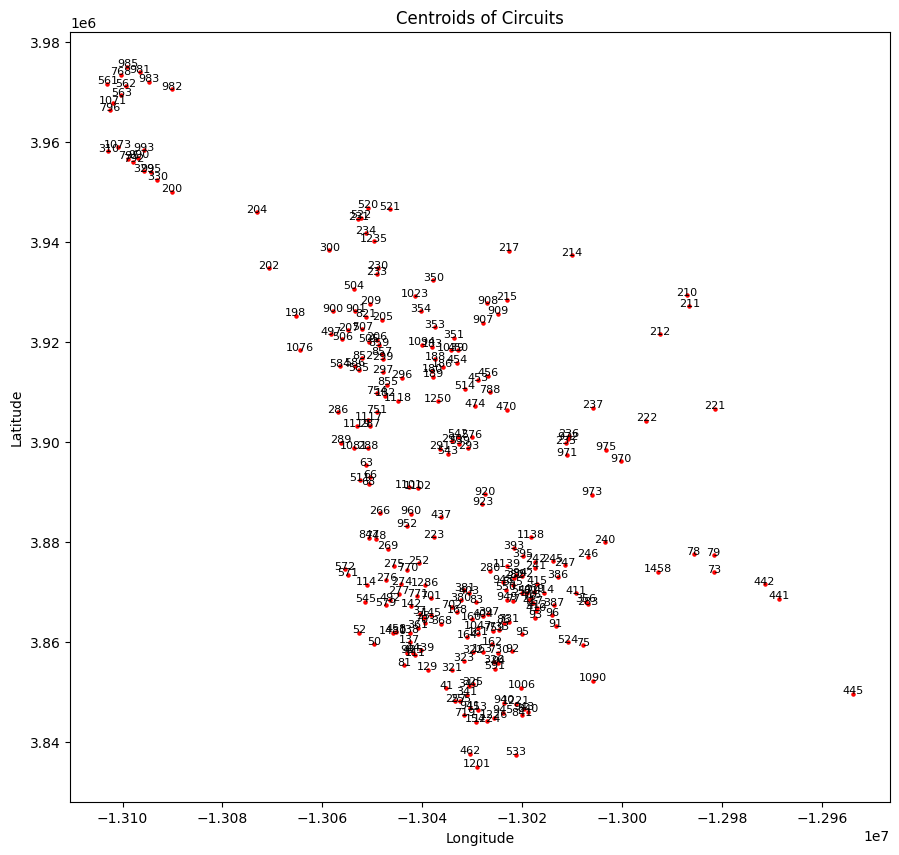

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(grouped_low_capacity_gdf, geometry='geometry')

gdf['centroid'] = gdf.geometry.centroid

fig, ax = plt.subplots(figsize=(15, 10))

gdf.set_geometry('centroid').plot(ax=ax, marker='o', color='red', markersize=5)
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)

for x, y, label in zip(gdf.centroid.x, gdf.centroid.y, gdf['CIRCUIT_NAME']):
    ax.text(x, y, label, fontsize=8, ha='center')

ax.set_title('Centroids of Circuits')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
